C:\Users\satya\AppData\Local\Temp\ipykernel_16000\1094536643.py:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


Extracting Data of Class: NonViolence
Extracting Data of Class: Violence
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 16, 12288)         0         
                                                                 
 lstm (LSTM)                 (None, 16, 64)            3162368   
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                 

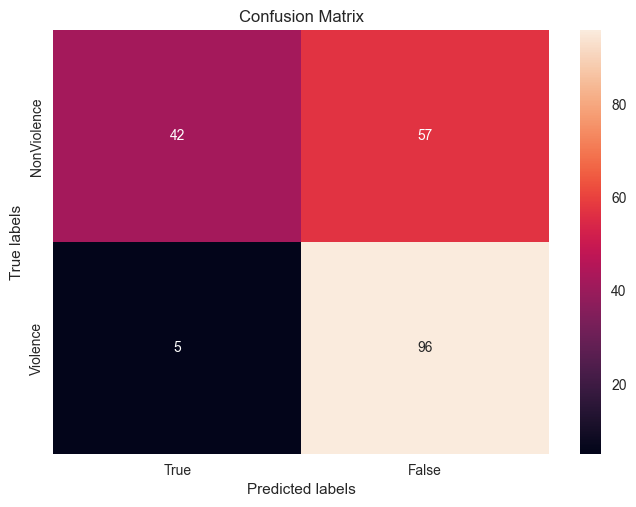

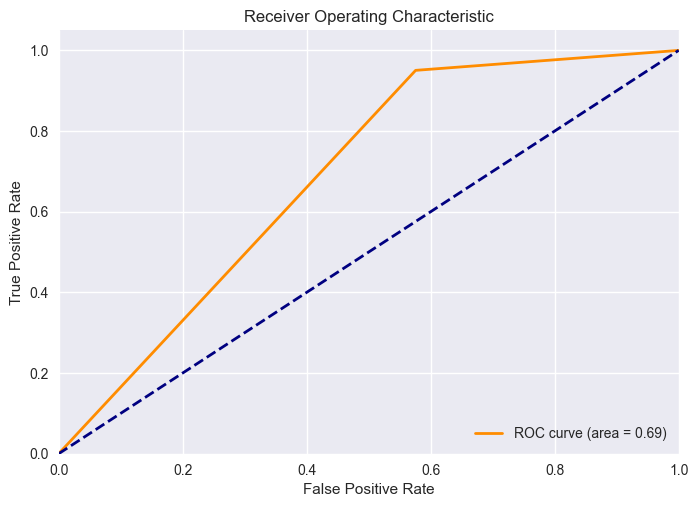

In [1]:
# Import necessary libraries
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import keras
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from IPython.display import HTML
from base64 import b64encode
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

plt.style.use("seaborn")
%matplotlib inline

# To Show a Video in the Notebook
def Play_Video(filepath):
    html = ''
    video = open(filepath, 'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

# Classes Directories
NonViolnceVideos_Dir = "C://Users//satya//Documents//Violence_Detection//Violence_Dataset_1//Real Life Violence Dataset//NonViolence"
ViolnceVideos_Dir = "C://Users//satya//Documents//Violence_Detection//Violence_Dataset_1//Real Life Violence Dataset//Violence"

# Retrieve the list of all the video files present in the Class Directory.
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

# Randomly select a video file from the Classes Directory.
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 16

DATASET_DIR = "C://Users//satya//Documents//Violence_Detection//Violence_Dataset_1//Real Life Violence Dataset"

CLASSES_LIST = ["NonViolence", "Violence"]

def frames_extraction(video_path):
    frames_list = []

    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes.
    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their respective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

# Create the dataset.
features, labels, video_files_paths = create_dataset()

# Saving the extracted data
np.save("features.npy", features)
np.save("labels.npy", labels)
np.save("video_files_paths.npy", video_files_paths)

features, labels, video_files_paths = np.load("features.npy"), np.load("labels.npy"), np.load("video_files_paths.npy")

# Convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

# Split the Data into Train (90%) and Test Set (10%).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size=0.1, shuffle=True, random_state=42)

# Create an RNN Model
def create_rnn_model():
    model = Sequential()

    # Specifying Input to match features shape
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    # Reshape the input to be suitable for an RNN
    model.add(Reshape((SEQUENCE_LENGTH, IMAGE_HEIGHT * IMAGE_WIDTH * 3)))

    # RNN Layer
    model.add(LSTM(units=64, return_sequences=True))
    model.add(LSTM(units=64, return_sequences=False))

    model.add(Dropout(0.25))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()

    return model

# Constructing the RNN Model
RNN_model = create_rnn_model()

# Plot the structure of the constructed RNN model.
plot_model(RNN_model, to_file='RNN_model_structure_plot.png', show_shapes=True, show_layer_names=True)

# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, min_lr=0.00005, verbose=1)

# Compiling the RNN model
RNN_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=["accuracy"])

# Fitting the RNN model
RNN_model_history = RNN_model.fit(x=features_train, y=labels_train, epochs=20, batch_size=8,
                                  shuffle=True, validation_split=0.1, callbacks=[early_stopping_callback, reduce_lr])

# Model evaluation
model_evaluation_history = RNN_model.evaluate(features_test, labels_test)

# Predict on the test set
labels_predict = RNN_model.predict(features_test)

# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict, axis=1)
labels_test_normal = np.argmax(labels_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(labels_test_normal, labels_predict)
precision = precision_score(labels_test_normal, labels_predict)
recall = recall_score(labels_test_normal, labels_predict)
f1 = f1_score(labels_test_normal, labels_predict)
roc_auc = roc_auc_score(labels_test_normal, labels_predict)

print('Accuracy Score:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)
print('ROC AUC:', roc_auc)

# Confusion Matrix
ax = plt.subplot()
cm = confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['NonViolence', 'Violence'])

# Generate ROC Curve
fpr, tpr, _ = roc_curve(labels_test_normal, labels_predict)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
